# Predicción de sentimiento en críticas de películas de IMDB

En este Notebook se llevará a cabo el ejemplo práctico de predicción de sentimiento en críticas de películas de IMDB del capítulo 6 del libro _"Deep Learning con Python"_, de François Chollet, titulado _"Deep Learning para texto y secuencias"_.

## 1. Aprendizaje de embeddings con la capa Embedding

### 1.1 Preprocesamiento
Para empezar, es necesario preparar los datos de entrenamiento.

En este caso, siguiendo el ejemplo, se restringirán las críticas a las 10000 palabras más habituales y se cortarán tras 20 palabras.

In [2]:
import warnings
warnings.filterwarnings('ignore')
from keras.datasets import imdb
from keras import preprocessing

Using TensorFlow backend.


In [3]:
max_palabras = 10000 #Número de palabras más habituales que se utilizarán, en nuestro caso, 10000
maxlen = 20          #Número de palabras tras las que se cortará la crítica

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_palabras)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen = maxlen)

### 1.2 Preparación y entrenamiento del modelo
Ahora se creará el modelo. La red aprenderá primero embeddings de 8 dimensiones, es decir, aprenderá 8 "matices" que sirvan para relacionar cada palabra con el resto. 

Tras esta primera capa de Embedding, se aplanará el tensor resultante para que pase de ser un tensor 3D flotante a ser uno 2D de enteros. Esto es necesario para el correcto entrenamiento de la capa Dense final, que será la encargada de la clasificación.

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length = maxlen)) #Tras esta capa el tensor resultante 
                                                      #es de la forma (muestras, maxlen, 8)

model.add(Flatten()) #Esta capa aplana el tensor anterior, quedando con la siguiente forma: 
                     #(muestras, maxlen * 8)

model.add(Dense(1, activation = 'sigmoid')) #Este es el clasificador, con una sola neurona 
                                            #que dará como resultado 0 o 1
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 117us/step - loss: 0.6771 - acc: 0.6042 - val_loss: 0.6394 - val_acc: 0.6904
Epoch 2/10
20000/20000 [==============================] - 2s 81us/step - loss: 0.5647 - acc: 0.740

El resultado es alrededor de un 75% de precisión en la validación. No está mal, pero podría mejorarse.

## 2. Utilización de embeddings preentrenados

En este ejemplo cambiará la estructura de los datos de entrada. Se trata de un conjunto de críticas de IMDB que tienen asociadas una lista de etiquetas. Entre las etiquetas pueden encontrarse _'pos'_, si es positiva, y _'neg'_ si es negativa.

### 2.1 Preprocesamiento
Para este segundo modelo se hará uso de datos de IMDB encontrados en el siguiente enlace: [Datos de IMDB](http://mng.bz/0tIo)

Recogeremos las críticas en una lista de cadenas, siendo una cadena una crítica. También se recogerá si la crítica es positiva o negativa en una lista _"labels"_.

In [5]:
import os

imdb_dir = 'E:/Universidad/TFG/IMDB/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

Ahora se vectorizará el texto y se realizará una división del conjunto de datos de entrenamiento y de validación. Los embeddings de palabras preentrenados son especialmente efectivos en problemas con pocos datos, por eso, se restringirá el conjunto de entrenamiento a 200 muestras.

También se tokenizarán las palabras, de manera que se asocie un número único a cada una de ellas.

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Se han encontrado %s tokens únicos.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Forma del tensor de datos: ', data.shape)
print('Forma del tensor de etiquetas: ', labels.shape)

indices = np.arange(data.shape[0])   #Estas líneas mezclan las críticas, dado que primero aparecen todas las
np.random.shuffle(indices)           #críticas negativas y luego todas las positivas
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Se han encontrado 88582 tokens únicos.
Forma del tensor de datos:  (25000, 100)
Forma del tensor de etiquetas:  (25000,)


### 2.2 Preparación de los embeddings
Los embeddings de palabras de los que se hará uso son de GloVe, en concreto es el archivo comprimido glove.6B.zip, el cual se encuentra aquí: [Embeddings de palabras de GloVe](https://nlp.stanford.edu/projects/glove)

Una vez descomprimido, usaremos el archivo _"glove.6B.100d.txt"_, que contiene embeddings de 100 dimensiones para 400000 palabras.

Si observamos los archivos .txt tras descomprimir, podemos ver que la estructura que siguen es colocar la palabra al principio de la línea y después todos los datos de sus dimensiones. Leeremos el archivo y lo estructuraremos en un diccionario que asocie la palabra con los coeficientes de sus 100 dimensiones.

In [7]:
glove_dir = 'E:/Universidad/TFG/IMDB/glove6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se han encontrado %s vectores de palabras.' % len(embeddings_index))

Se han encontrado 400000 vectores de palabras.


Ahora hay que adaptar la información para que se presente en una matriz de la forma (max_words, embedding_dim), de manera que pueda ser cargada en una capa Embedding.

Además, es necesario asociar el índice de palabras que generamos previamente para la tokenización con el índice de embeddings.

In [8]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():                    #Se comprueba cada palabra del índice de palabras de la tokenización
    if i < max_words:                                 #Si existe en el índice de embeddings se toman los coeficientes y se
        embedding_vector = embeddings_index.get(word) #colocan en la matriz siguiendo el orden del índice de tokens
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector #Las palabras que no estén en el embedding index serán todo ceros

### 2.3 Preparación del modelo
En este caso, usaremos el mismo modelo que en el ejemplo anterior con una capa Dense de 32 neuronas antes de la activación. Además habrá que cargar los embeddings preentrenados.
Para ello introduciremos los pesos de los embeddings de GloVe manualmente en la capa de Embedding y además congelaremos el entrenamiento de la capa, para que se mantengan.

In [9]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### 2.4 Entrenamiento del modelo
A continuación entrenaremos el modelo.

In [10]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data = (x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 1.6486 - acc: 0.4700 - val_loss: 0.6934 - val_acc: 0.5325
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5832 - acc: 0.7050 - val_loss: 1.0360 - val_acc: 0.5082
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4491 - acc: 0.8300 - val_loss: 1.1216 - val_acc: 0.4928
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5191 - acc: 0.6900 - val_loss: 0.6978 - val_acc: 0.5600
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2300 - acc: 0.9350 - val_loss: 0.6920 - val_acc: 0.5742
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1676 - acc: 0.9550 - val_loss: 1.8799 - val_acc: 0.4928
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2234 - acc: 0.9150 - val_loss: 0.7762 - val_acc: 0.5497
Epoch 8/10
200/200 [========

Ahora mostraremos los resultados del entrenamiento en gráficas

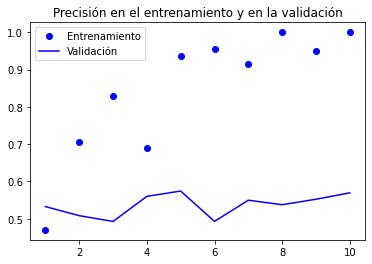

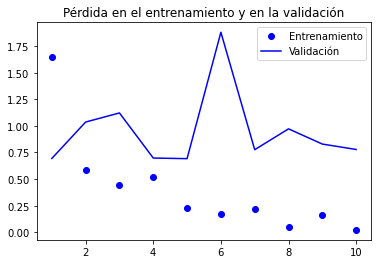

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Entrenamiento')
plt.plot(epochs, val_acc, 'b', label = 'Validación')
plt.title('Precisión en el entrenamiento y en la validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Entrenamiento')
plt.plot(epochs, val_loss, 'b', label = 'Validación')
plt.title('Pérdida en el entrenamiento y en la validación')
plt.legend()

plt.show()

Como puede observarse el modelo sufre sobreajuste, en el entrenamiento se alcanza un valor cercano al 100% de precisión, pero en la validación se obtiene algo más del 50%. Esto es debido a que solo se utilizan 200 muestras.

### 2.5 Cambio a embeddings específicos

A continuación probaremos a entrenar el modelo sin un embedding preentrenado. Los embeddings de palabras específicos son más efectivos en tareas con muchos datos, por lo que es de esperar que con tan solo 200 muestras no vaya a ser una opción demasiado viable.

In [14]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data = (x_val, y_val))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6977 - acc: 0.4850 - val_loss: 0.6922 - val_acc: 0.5217
Epoch 2/10
200/200 [==============================] - 1s 3ms/s

Mostramos los resultados

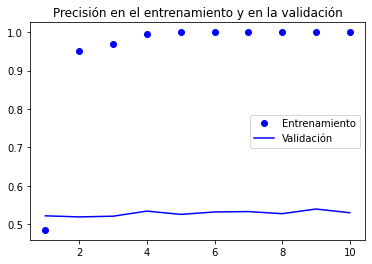

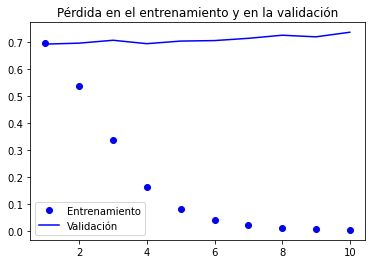

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Entrenamiento')
plt.plot(epochs, val_acc, 'b', label = 'Validación')
plt.title('Precisión en el entrenamiento y en la validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Entrenamiento')
plt.plot(epochs, val_loss, 'b', label = 'Validación')
plt.title('Pérdida en el entrenamiento y en la validación')
plt.legend()

plt.show()

Como podemos ver, hay de nuevo sobreajuste y esta vez la precisión en la validación es algo inferior que con embeddings preentrenados.

Sin embargo, ahora vamos a probar con más datos, solo para comprobar que efectivamente, los embeddings específicos funcionan mejor con conjuntos de datos grandes. Vamos a cambiar el conjunto de datos de validación (de 10000 muestras) por el de entrenamiento (200 muestras).

In [20]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_val, y_val, epochs = 10, batch_size = 32, validation_data = (x_train, y_train))
model.save_weights('embeddings_especificos_grande_model.h5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 200 samples
Epoch 1/10
10000/10000 [==============================] - 1s 133us/step - loss: 0.5103 - acc: 0.7313 - val_loss: 0.4356 - val_acc: 0.7750
Epoch 2/10
10000/10000 [==============================] 

A continuación mostramos las gráficas con los datos obtenidos

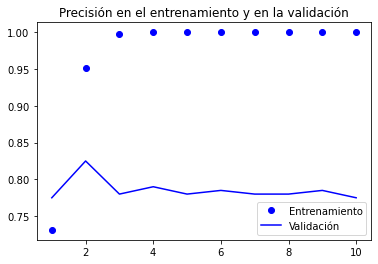

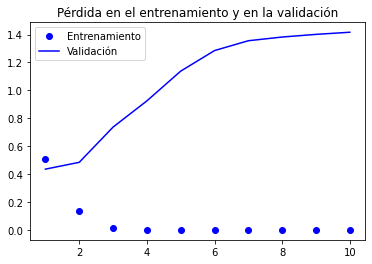

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Entrenamiento')
plt.plot(epochs, val_acc, 'b', label = 'Validación')
plt.title('Precisión en el entrenamiento y en la validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Entrenamiento')
plt.plot(epochs, val_loss, 'b', label = 'Validación')
plt.title('Pérdida en el entrenamiento y en la validación')
plt.legend()

plt.show()

Como podemos ver, también se produce sobreajuste, pero la precisión en la validación llega a estar alrededor del 79%, bastante mejor que con un conjunto de entrenamiento pequeño.

### 2.6 Evaluación del modelo
Para evaluar el modelo utilizaremos el conjunto de datos de prueba de IMDB que descargamos previamente.
Primero vamos a preparar los datos, tokenizándolos.

In [18]:
imdb_dir = 'E:/Universidad/TFG/IMDB/aclImdb'
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen = maxlen)
y_test = np.asarray(labels)

Ahora cargamos y evaluamos el primer modelo.

In [19]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 45us/step


[0.7936463269805908, 0.564520001411438]

Se consigue una precisión de alrededor del 56%, es un resultado bastante bajo, pero esperable.

Ahora probaremos con el modelo de embeddings específicos entrenado con un conjunto de datos grande, para comparar los resultados.

In [22]:
model.load_weights('embeddings_especificos_grande_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 49us/step


[1.0465596101862191, 0.8226000070571899]

Como podemos ver, este modelo es bastante mejor que el anterior, con más del 80% de precisión en la evaluación.